**Imports of all the libraries we need** 

In [1]:
from xgboost import XGBClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report

**Download the data sets**

In [2]:
!wget -cq https://www.dropbox.com/s/n0t1fi534rhycoc/electrical_grid_train.csv #Data train import

In [ ]:
!wget -cq https://www.dropbox.com/s/v20v43hwmkj1bol/electrical_grid_test.csv  #Data test import

**Load and analysis of the data sets**

In [3]:
train_data = pd.read_csv('electrical_grid_train.csv') 

In [ ]:
train_data.head()

tau1      tau2      tau3  ...        g3        g4     stabf
0  5.744900  8.203603  5.744900  ...  0.347608  0.203486  unstable
1  4.765284  7.227511  4.765284  ...  0.556773  0.735869  unstable
2  7.603216  1.556791  5.475538  ...  0.825894  0.441910    stable
3  6.931945  1.706944  6.931945  ...  0.332532  0.612462    stable
4  1.604168  0.937741  1.604168  ...  0.768862  0.063126    stable

[5 rows x 13 columns]

In [ ]:
train_data.corr() #Correlation, we may remove tau1|tau3 due to a high value, they maybe describing the same thing

tau1      tau2      tau3  ...        g2        g3        g4
tau1  1.000000  0.018327  0.897324  ...  0.017797 -0.005001  0.003678
tau2  0.018327  1.000000  0.021616  ...  0.017506  0.028040 -0.005822
tau3  0.897324  0.021616  1.000000  ...  0.008139 -0.009687  0.006779
tau4 -0.008974 -0.005647 -0.013984  ...  0.011775  0.005236 -0.003716
p1    0.031162 -0.004316  0.026722  ...  0.026612  0.001476 -0.017816
p2   -0.018839  0.010340 -0.023971  ... -0.026247  0.000339  0.018890
p3   -0.019588  0.008914 -0.006389  ... -0.012074 -0.002953 -0.006246
p4   -0.015770 -0.011734 -0.016142  ... -0.007990  0.000052  0.018373
g1    0.007780 -0.007413  0.001329  ...  0.005393 -0.009658  0.007221
g2    0.017797  0.017506  0.008139  ...  1.000000 -0.022642 -0.020621
g3   -0.005001  0.028040 -0.009687  ... -0.022642  1.000000  0.006945
g4    0.003678 -0.005822  0.006779  ... -0.020621  0.006945  1.000000

[12 rows x 12 columns]

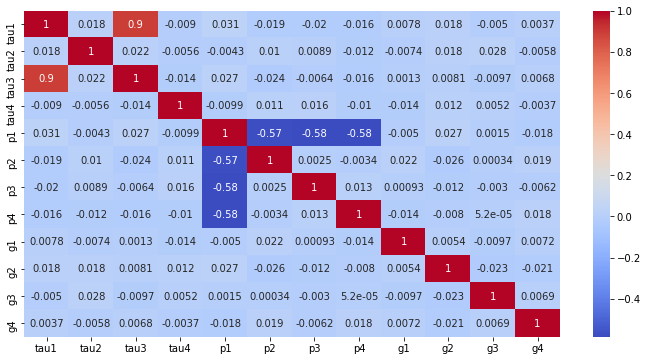

In [ ]:
plt.figure(figsize=(12,6))
sns.heatmap(train_data.corr(),cmap='coolwarm', annot=True) #Drawing beacuse its fancy looking, and easier to see the correlation

In [ ]:
train_data.info() #There is no empty data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   tau1    7500 non-null   float64
 1   tau2    7500 non-null   float64
 2   tau3    7500 non-null   float64
 3   tau4    7500 non-null   float64
 4   p1      7500 non-null   float64
 5   p2      7500 non-null   float64
 6   p3      7500 non-null   float64
 7   p4      7500 non-null   float64
 8   g1      7500 non-null   float64
 9   g2      7500 non-null   float64
 10  g3      7500 non-null   float64
 11  g4      7500 non-null   float64
 12  stabf   7500 non-null   object 
dtypes: float64(12), object(1)
memory usage: 761.8+ KB


In [4]:
train_data.describe()

tau1         tau2  ...           g3           g4
count  7500.000000  7500.000000  ...  7500.000000  7500.000000
mean      5.228858     4.520797  ...     0.526879     0.525536
std       2.738370     2.752313  ...     0.274261     0.275539
min       0.501331    -0.225671  ...     0.050054     0.050028
25%       2.866791     2.132227  ...     0.289900     0.284966
50%       5.218495     4.505940  ...     0.527572     0.523747
75%       7.587219     6.911618  ...     0.764014     0.766536
max       9.998995     9.274024  ...     0.999839     0.999930

[8 rows x 12 columns]

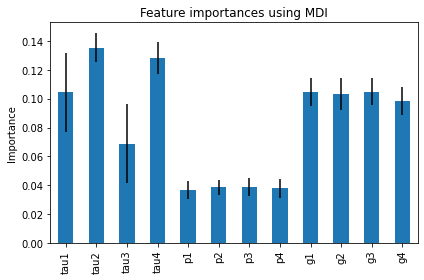

In [ ]:
#We divide X and y just to se the importance of the features, so if the model isn't precise enough maybe removing some less importante features we get a better precision
X = train_data.drop(['stabf'], axis=1) 
y = train_data.stabf

#Train with a random forest
forest = RandomForestClassifier(random_state=0)
forest.fit(X, y)

#And we get the list of features and its level of importance
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

#Print for easy view
forest_importances = pd.Series(importances, index=["tau1", "tau2", "tau3", "tau4", "p1", "p2", "p3", "p4", "g1", "g2", "g3", "g4"])
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Importance")
fig.tight_layout()

**Generating *X* and *y* and all the parameters of the different models**

In [ ]:
#Preparation of all the parameters
pBayes = {
    'priors':[None]
}

pSVM = {
    'C':[1.0]
}

pDecisionTree = {
    'max_depth' : [1,3,5,7,8,11,20],
    'min_samples_split' : [3,5,7,9,10,25],
    'criterion' : ['gini','entropy']
}

pLogisticRegresion = {
    'penalty':["l2"]
}

pRandomForest = {
    'criterion' : ['gini', 'entropy'],
    'max_depth' : range(6,9),
    'n_estimators' : [50, 100, 125],
    'max_features' : [0.25, 0.5, 0.75, "sqrt"],
    'random_state' : [2]
}

pXGBoost = {
    'n_estimators': [750, 800],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'max_depth': [3,5],
    'reg_alpha': [1.7, 1.8],
    'reg_lambda': [2.3, 2.4],
    'subsample': [0.7, 0.8, 0.9],
    'random_state' : [2]
}

In [ ]:
#Divide the data in X and y(stabf)
#I've dicided the remove this colums due to hihg correlation (tau3) and low importance (p1,p2,p3,p4)
X = train_data.drop(['stabf', 'tau3', 'p1', 'p2', 'p3', 'p4'], axis=1) 
y = train_data.stabf

**Training all the models**

In [ ]:
params = [pBayes, pSVM, pDecisionTree, pLogisticRegresion, pRandomForest, pXGBoost]
models = [GaussianNB(), SVC(), DecisionTreeClassifier(), LogisticRegression(), RandomForestClassifier(oob_score=True),XGBClassifier()]
names = ["Bayes", "SVM", "Decision Tree", "Logistic Regresion", "RandomForest", "XGBoost"]

model_store = []      #Keep all the models, just to at the end use the one that best suit us
accuracy_scores = []  #Store all the socres of the different models, to then pick one 

for param, model, name in zip(params, models, names):
  print(name) 

  model_grid = GridSearchCV(model, param_grid = param, cv=5, verbose=1, n_jobs=-1)  #Model
  model_grid.fit(X, y)                                                              #Train

  model_store.append(model_grid)
  accuracy_scores.append(model_grid.best_score_)

  print(model_grid.best_score_)  #Accuracy
  print(model_grid.best_params_) #Parameters


Bayes
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


0.8081333333333334
{'priors': None}
SVM
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.4s finished


0.8512000000000001
{'C': 1.0}
Decision Tree
Fitting 5 folds for each of 84 candidates, totalling 420 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 300 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 420 out of 420 | elapsed:   18.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


0.8165333333333334
{'criterion': 'entropy', 'max_depth': 8, 'min_samples_split': 25}
Logistic Regresion
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


0.7938666666666666
{'penalty': 'l2'}
RandomForest
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   36.0s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  6.5min finished


0.8624
{'criterion': 'gini', 'max_depth': 8, 'max_features': 0.5, 'n_estimators': 125, 'random_state': 2}
XGBoost
Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 20.9min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed: 36.7min finished


0.8702666666666665
{'colsample_bytree': 0.8, 'max_depth': 3, 'n_estimators': 800, 'random_state': 2, 'reg_alpha': 1.8, 'reg_lambda': 2.4, 'subsample': 0.9}


**Analysis of the test data**

In [ ]:
test_data = pd.read_csv('electrical_grid_test.csv') 

In [ ]:
test_data.head()

tau1      tau2      tau3  ...        g3        g4     stabf
0  3.198395  1.998723  3.198395  ...  0.655529  0.716621  unstable
1  7.295651  0.390647  7.295651  ...  0.331460  0.161048    stable
2  3.766899  5.681400  3.766899  ...  0.519634  0.810315  unstable
3  1.412934  5.363109  1.412934  ...  0.079277  0.841257  unstable
4  2.488778  7.751648  2.488778  ...  0.622356  0.394018  unstable

[5 rows x 13 columns]

In [ ]:
test_data.corr() #Same as before there is a huge correlation betwen tau1|tau3

tau1      tau2      tau3  ...        g2        g3        g4
tau1  1.000000  0.007185  0.916967  ...  0.008101  0.010458  0.011200
tau2  0.007185  1.000000  0.004340  ...  0.009085 -0.018487 -0.030165
tau3  0.916967  0.004340  1.000000  ...  0.004703 -0.000684  0.000948
tau4 -0.041844  0.009000 -0.036587  ... -0.001215 -0.002323  0.009266
p1    0.015767 -0.006071  0.018795  ... -0.017577 -0.000688 -0.008281
p2   -0.005743 -0.004935  0.003091  ...  0.005881  0.029454  0.022722
p3   -0.005441  0.003754 -0.011658  ... -0.010241 -0.014336 -0.023470
p4   -0.016102  0.011739 -0.024040  ...  0.034737 -0.014164  0.014875
g1    0.018482  0.015495  0.006948  ...  0.013836  0.005848  0.028438
g2    0.008101  0.009085  0.004703  ...  1.000000  0.016022  0.002101
g3    0.010458 -0.018487 -0.000684  ...  0.016022  1.000000  0.006604
g4    0.011200 -0.030165  0.000948  ...  0.002101  0.006604  1.000000

[12 rows x 12 columns]

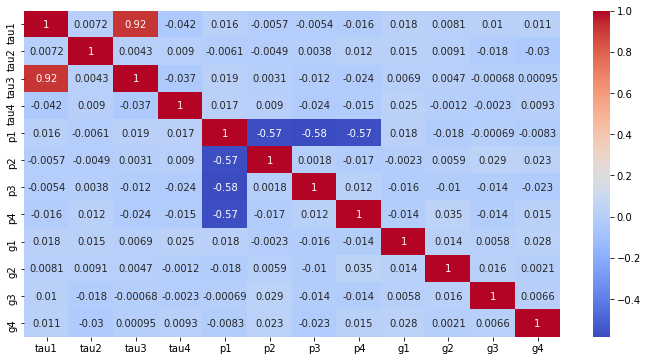

In [ ]:
plt.figure(figsize=(12,6))
sns.heatmap(test_data.corr(),cmap='coolwarm', annot=True) 

In [ ]:
test_data.info() #There is no null data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   tau1    2500 non-null   float64
 1   tau2    2500 non-null   float64
 2   tau3    2500 non-null   float64
 3   tau4    2500 non-null   float64
 4   p1      2500 non-null   float64
 5   p2      2500 non-null   float64
 6   p3      2500 non-null   float64
 7   p4      2500 non-null   float64
 8   g1      2500 non-null   float64
 9   g2      2500 non-null   float64
 10  g3      2500 non-null   float64
 11  g4      2500 non-null   float64
 12  stabf   2500 non-null   object 
dtypes: float64(12), object(1)
memory usage: 254.0+ KB


**Dividing the test data in *X* and *y***

In [ ]:
XTest = test_data.drop(['stabf', 'tau3', 'p1', 'p2', 'p3', 'p4'], axis=1) #Divide the data in X and y(stabf)
yTest = test_data.stabf

**Test data check**

In [ ]:
accuracy_index = max(range(len(accuracy_scores)), key=accuracy_scores.__getitem__) #Black python magic, heresy (Gets the index of the maximum value in a list)
yModelScore = model_store[accuracy_index].predict(XTest)

In [ ]:
confusion_matrix(yTest, yModelScore)
print(classification_report(yTest, yModelScore))

              precision    recall  f1-score   support

      stable       0.84      0.79      0.81       910
    unstable       0.88      0.91      0.90      1590

    accuracy                           0.87      2500
   macro avg       0.86      0.85      0.86      2500
weighted avg       0.87      0.87      0.87      2500

